## ***Import Libraries***

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')

## ***Define Paths and Prepare for Data***

In [2]:
train_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
val_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

In [3]:
class BraTSDataset(Dataset):
    def __init__(self, patient_list, data_dir, is_train=True, transform=None, slice_range=(60, 100)):
        self.data_dir = data_dir
        self.is_train = is_train
        self.transform = transform
        self.modalities = ["flair", "t1", "t1ce", "t2"]
        self.patients = [p for p in patient_list if not p.endswith(".csv")]
        self.slice_range = slice_range  # Only load a range of slices to save memory
        
    def load_nifti(self, path):
        nifti_img = nib.load(path)
        return np.array(nifti_img.get_fdata(), dtype=np.float32)
    
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_path = os.path.join(self.data_dir, patient_id)
        
        # Load 4 MR modalities
        images = []
        for modality in self.modalities:
            img_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
            img = self.load_nifti(img_path)
            
            # Only keep the central axial slices where tumor is most likely to be visible
            # This significantly reduces memory usage
            start_slice, end_slice = self.slice_range
            img = img[:, :, start_slice:end_slice]
            
            images.append(img)
            
        # Stack images as channels
        images = np.stack(images, axis=0)  # (4, H, W, D_reduced)
        
        # Normalize
        for i in range(len(images)):
            img = images[i]
            min_val = img.min()
            max_val = img.max()
            if max_val > min_val:
                images[i] = (img - min_val) / (max_val - min_val)
            else:
                images[i] = img * 0
        
        # To PyTorch Tensor
        images = torch.tensor(images, dtype=torch.float32)
        
        # If it is a train_set load segmentation mask too
        if self.is_train:
            seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
            mask = self.load_nifti(seg_path)
            
            # Get the same slice range
            mask = mask[:, :, self.slice_range[0]:self.slice_range[1]]
            
            # Convert to binary mask
            mask = (mask > 0).astype(np.float32)
            mask = torch.tensor(mask, dtype=torch.long)
        else:
            mask = None
                
        return (images, mask) if self.is_train else images

# Optimize memory by selecting a subset of patients for quick testing
def get_subset_patients(patient_list, ratio=0.3):
    """Get a subset of patients for memory-efficient training"""
    n_patients = max(2, int(len(patient_list) * ratio))
    return random.sample(patient_list, n_patients)

In [4]:
# Prepare datasets (with memory optimization)
all_train_patients = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
all_test_patients = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])

# For quick testing/debugging, use smaller subset
use_subset = True  # Set to False for full training
if use_subset:
    all_train_patients = get_subset_patients(all_train_patients, ratio=0.2)
    all_test_patients = get_subset_patients(all_test_patients, ratio=0.2)

print(f"Using {len(all_train_patients)} training patients and {len(all_test_patients)} test patients")

# Split training data into train and validation
train_patients, val_patients = train_test_split(all_train_patients, test_size=0.2, random_state=42)

# Create datasets with reduced slice range to save memory
train_dataset = BraTSDataset(train_patients, train_dir, slice_range=(60, 100))
val_dataset = BraTSDataset(val_patients, train_dir, slice_range=(60, 100))
test_dataset = BraTSDataset(all_test_patients, val_dir, is_train=False, slice_range=(60, 100))

# DataLoaders with smaller batch_size
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Check sample data dimensions
sample_img, sample_mask = next(iter(train_loader))
print(f"Train set image dimension: {sample_img.shape}")  # Should be smaller now
print(f"Train set segmentation dimension: {sample_mask.shape}")

sample_img, sample_mask = next(iter(val_loader))
print("Validation set image dimension:", sample_img.shape)
print("Validation set segmentation dimension:", sample_mask.shape)

sample_img = next(iter(test_loader))
print("Test set image dimension:", sample_img.shape)

Using 73 training patients and 25 test patients
Train set image dimension: torch.Size([1, 4, 240, 240, 40])
Train set segmentation dimension: torch.Size([1, 240, 240, 40])
Validation set image dimension: torch.Size([1, 4, 240, 240, 40])
Validation set segmentation dimension: torch.Size([1, 240, 240, 40])
Test set image dimension: torch.Size([1, 4, 240, 240, 40])


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    torch.cuda.empty_cache()  # Clear GPU cache before starting
    print(f"Using {num_gpus} GPUs for training." if num_gpus > 1 else 
          f"Using {torch.cuda.get_device_name(0)} for training.")
else:
    print("Using CPU for training.")

Using 2 GPUs for training.


## ***Building Model Architecture, Dice Loss and Setting Hyperparameters***

In [6]:
# Memory-optimized 3D UNet model
class LightUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, base_filters=16):
        super(LightUNet3D, self).__init__()
        
        # Use fewer filters to reduce memory usage
        self.encoder1 = nn.Sequential(
            nn.Conv3d(in_channels, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_filters),
            nn.ReLU(inplace=True)
        )
        
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.encoder2 = nn.Sequential(
            nn.Conv3d(base_filters, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_filters*2),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose3d(base_filters*2, base_filters, kernel_size=2, stride=2)
        
        self.decoder1 = nn.Sequential(
            nn.Conv3d(base_filters*2, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_filters),
            nn.ReLU(inplace=True)
        )
        
        self.final_conv = nn.Conv3d(base_filters, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        p1 = self.pool1(enc1)
        
        # Bottom level
        enc2 = self.encoder2(p1)
        
        # Decoder
        upconv1 = self.upconv1(enc2)
        
        # Handle size mismatches
        diffY = enc1.size()[2] - upconv1.size()[2]
        diffX = enc1.size()[3] - upconv1.size()[3]
        diffZ = enc1.size()[4] - upconv1.size()[4]
        
        upconv1 = nn.functional.pad(upconv1, [
            diffZ // 2, diffZ - diffZ // 2,
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        
        # Concatenate and decode
        concat1 = torch.cat([upconv1, enc1], dim=1)
        dec1 = self.decoder1(concat1)
        
        # Final classification layer
        out = self.final_conv(dec1)
        
        return out

In [7]:
# Initialize model with fewer parameters to reduce memory usage
model = LightUNet3D(in_channels=4, out_channels=2, base_filters=12)
model = model.to(device)

# Use mixed precision for memory efficiency
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# Dice coefficient for evaluation
def dice_coefficient(y_pred, y_true, smooth=1e-6):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    return (2.0 * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

## ***Train-Validation Functions***

In [9]:
# Function to train for one epoch with memory optimization
def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    model.train()
    epoch_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    dice_score = 0.0
    batch_count = 0
    
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard forward and backward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # Update metrics
        epoch_loss += loss.item()
        
        # Get predictions
        _, preds = torch.max(outputs, 1)
        
        # Calculate accuracy
        correct_pixels += (preds == targets).sum().item()
        total_pixels += targets.numel()
        
        # Calculate Dice coefficient
        dice_score += dice_coefficient(preds, targets)
        batch_count += 1
        
        # Print progress
        if (i+1) % 5 == 0:
            print(f"Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")
            
        # Free up memory
        del inputs, targets, outputs, preds
        torch.cuda.empty_cache()
    
    # Calculate average metrics
    avg_loss = epoch_loss / batch_count
    avg_accuracy = 100.0 * correct_pixels / total_pixels if total_pixels > 0 else 0
    avg_dice = dice_score / batch_count
    
    return avg_loss, avg_accuracy, avg_dice

# Function to validate for one epoch with memory optimization
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    dice_score = 0.0
    batch_count = 0
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Update statistics
            epoch_loss += loss.item()
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Calculate accuracy
            correct_pixels += (preds == targets).sum().item()
            total_pixels += targets.numel()
            
            # Calculate Dice coefficient
            dice_score += dice_coefficient(preds, targets)
            batch_count += 1
            
            # Free up memory
            del inputs, targets, outputs, preds
            torch.cuda.empty_cache()
    
    # Calculate average metrics
    avg_loss = epoch_loss / batch_count
    avg_accuracy = 100.0 * correct_pixels / total_pixels if total_pixels > 0 else 0
    avg_dice = dice_score / batch_count
    
    return avg_loss, avg_accuracy, avg_dice

## ***Training***

In [10]:
# Training loop
num_epochs = 30
best_val_loss = float('inf')

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_dice_scores = []
val_dice_scores = []

try:
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        
        # Train
        train_loss, train_acc, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_dice_scores.append(train_dice)
        
        # Free memory before validation
        torch.cuda.empty_cache()
        
        # Validate
        val_loss, val_acc, val_dice = validate_one_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_dice_scores.append(val_dice)
        
        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        print(f"Train Dice: {train_dice:.4f}, Validation Dice: {val_dice:.4f}")
        
        # Save the best model (entire model, not just weights)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, 'best_brats_model.pt')  # 🎯 Modeli komple kaydet
            print("Best model saved!")

        # Free memory after each epoch
        torch.cuda.empty_cache()

except Exception as e:
    print(f"Error during training: {e}")
    # Save the model even if training is interrupted
    torch.save(model, 'interrupted_brats_model.pt')  # 🎯 Kesintiye uğrarsa modeli kaydet
    print("Model saved despite interruption!")

print("Training completed!")

Epoch [1/30]
Batch 5/58, Loss: 1.0179
Batch 10/58, Loss: 1.0308
Batch 15/58, Loss: 0.9144
Batch 20/58, Loss: 0.9609
Batch 25/58, Loss: 0.9254
Batch 30/58, Loss: 0.8747
Batch 35/58, Loss: 0.9131
Batch 40/58, Loss: 0.8919
Batch 45/58, Loss: 0.9128
Batch 50/58, Loss: 0.8641
Batch 55/58, Loss: 0.8566
Epoch [1/30], Train Loss: 0.9243, Train Accuracy: 8.87%, Validation Loss: 0.9103, Validation Accuracy: 3.76%
Train Dice: 0.0582, Validation Dice: 0.0698
Best model saved!
Epoch [2/30]
Batch 5/58, Loss: 0.8779
Batch 10/58, Loss: 0.8429
Batch 15/58, Loss: 0.8446
Batch 20/58, Loss: 0.8297
Batch 25/58, Loss: 0.8261
Batch 30/58, Loss: 0.7752
Batch 35/58, Loss: 0.8211
Batch 40/58, Loss: 0.8083
Batch 45/58, Loss: 0.7435
Batch 50/58, Loss: 0.7784
Batch 55/58, Loss: 0.7603
Epoch [2/30], Train Loss: 0.8079, Train Accuracy: 31.26%, Validation Loss: 0.7796, Validation Accuracy: 65.78%
Train Dice: 0.0838, Validation Dice: 0.1719
Best model saved!
Epoch [3/30]
Batch 5/58, Loss: 0.7626
Batch 10/58, Loss: 0.7

## ***Evaluation and Prediction***

Error creating plots: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


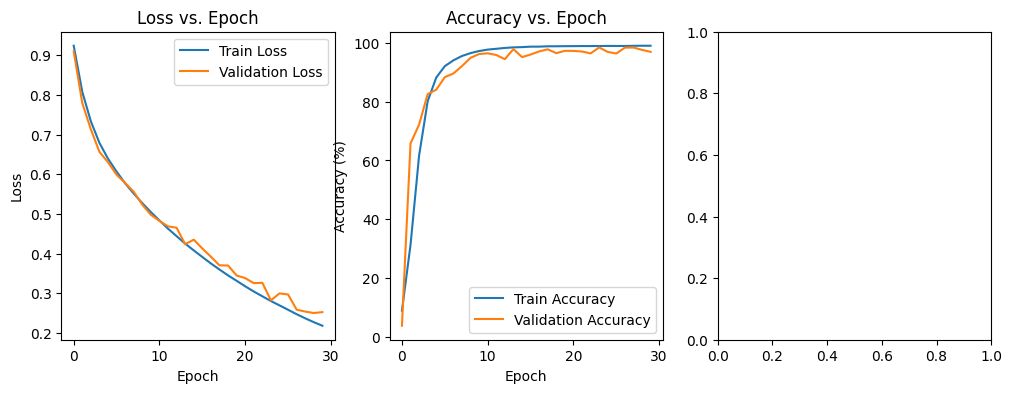

In [11]:
# Plot metrics only if training completed
if len(train_losses) > 0:
    try:
        import matplotlib.pyplot as plt
        
        # Plot losses
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss vs. Epoch')
        
        # Plot accuracies
        plt.subplot(1, 3, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Accuracy vs. Epoch')
        
        # Plot Dice scores
        plt.subplot(1, 3, 3)
        plt.plot(train_dice_scores, label='Train Dice')
        plt.plot(val_dice_scores, label='Validation Dice')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Coefficient')
        plt.legend()
        plt.title('Dice Coefficient vs. Epoch')
        
        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()
    except Exception as e:
        print(f"Error creating plots: {e}")

In [12]:
# Modeli yükle
model_path = "/kaggle/working/best_brats_model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli oluştur ve ağırlıkları yükle
model = torch.load(model_path, map_location=device)
model = model.to(device)
model.eval()  # Modeli inference moduna al

LightUNet3D(
  (encoder1): Sequential(
    (0): Conv3d(4, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv3d(12, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv1): ConvTranspose3d(24, 12, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (decoder1): Sequential(
    (0): Conv3d(24, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (final_conv): Conv3d(12, 2, kernel_size=(1, 1, 1), stride=(1, 1, 1))
)

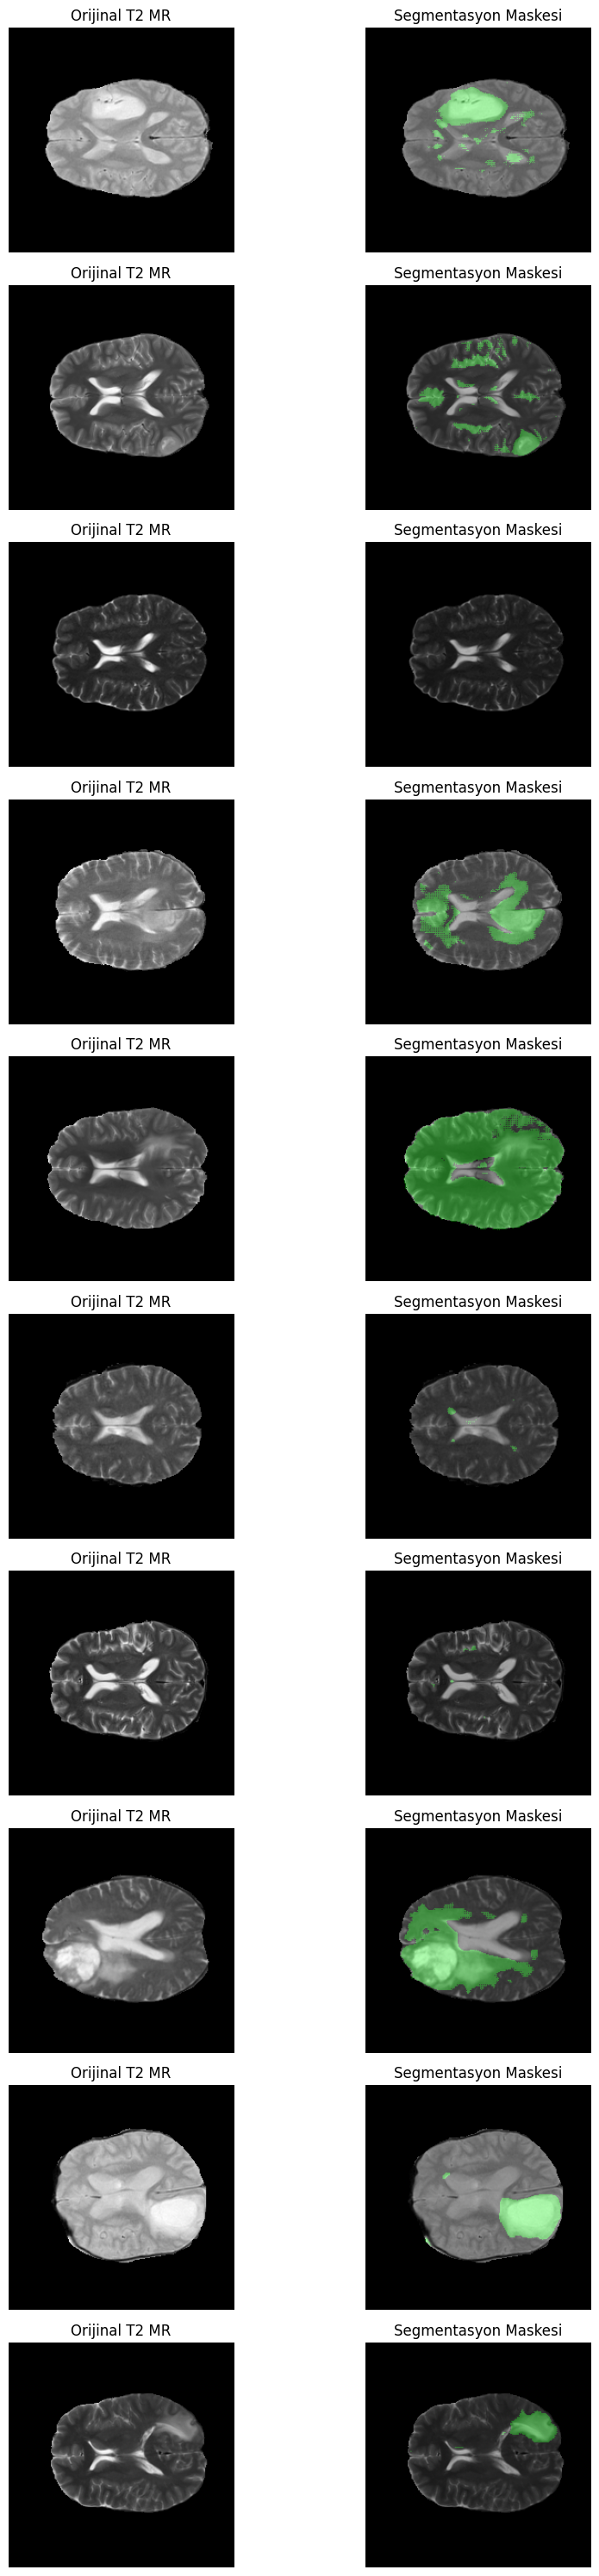

In [13]:
# Take random 10 images
test_iter = iter(test_loader)
num_images = 10
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

for i in range(num_images):
    test_image = next(test_iter).to(device)  # (1, 4, H, W, D)

    # Prediction with model
    with torch.no_grad():
        output = model(test_image)  # (1, 2, H, W, D)
        prediction = torch.argmax(output, dim=1).cpu().numpy()  # (1, H, W, D)

    # Transform to numpy
    test_image_np = test_image.cpu().numpy()

    # Select middle slice (e.g. D/2)
    slice_idx = test_image_np.shape[4] // 2  # Depth axis D
    t2_slice = test_image_np[0, 3, :, :, slice_idx]  # T2 modality
    pred_mask = prediction[0, :, :, slice_idx]  # Segmentation mask

    # Normalize and convert to 8-bit (For Image)
    t2_slice = cv2.normalize(t2_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Make it colorful
    t2_colored = cv2.cvtColor(t2_slice, cv2.COLOR_GRAY2BGR)

    # Color the segmentation mask
    mask_colored = np.zeros_like(t2_colored)
    mask_colored[:, :, 1] = (pred_mask * 255).astype(np.uint8)  # Green mask

    # Overlay segmentation transparently onto image
    blended = cv2.addWeighted(t2_colored, 0.7, mask_colored, 0.3, 0)

    # Draw images
    axes[i, 0].imshow(t2_colored)
    axes[i, 0].set_title("Orijinal T2 MR")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(blended)
    axes[i, 1].set_title("Segmentasyon Maskesi")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## ***Conclusion***

In this study, a deep learning pipeline was created using the 3D U-Net model for brain tumor segmentation. The study includes the following steps:

### ***1. Data Preparation***
MRI images containing FLAIR, T1, T1CE and T2 modalities from the BraTS (Brain Tumor Segmentation) dataset were used.
The BraTSDataset class was created and the PyTorch dataset and data loaders (DataLoader) were configured.
For memory optimization, only the 60-100th slice range where tumors are most frequently seen was used.
The images were normalized to ensure more efficient learning of the model.

### ***2. Model Training***
The 3D U-Net model was defined and trained with GPU acceleration.
The segmentation performance of the model was optimized using Dice Loss.
The best model was recorded as "best_brats_model.pt" according to the validation Dice Score.

### ***3. Testing and Evaluation***
The trained model was evaluated on the test dataset.
Predictions were made on 10 different test images and segmentation masks were generated.
The predicted segmentation masks were visualized by overlaying the original MRI images with OpenCV.

### ***4. Results and Future Work***
The model made successful predictions on tumor segmentation.
When evaluated on the images, it was seen that the tumor areas were clearly separated.

In the future, data augmentation, larger data sets or transfer learning methods can be used to increase the accuracy of the model.
This study demonstrates the effectiveness of deep learning models for MRI-based brain tumor segmentation. The model can be used as a system that provides automatic tumor detection and segmentation that can assist doctors 🚀